In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scikit-fmm
!pip install cairosvg
!pip install svgwrite

In [4]:
!unzip /content/drive/MyDrive/problems.zip

Archive:  /content/drive/MyDrive/problems.zip
replace problems/occlusion2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace problems/occlusion1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace problems/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import cairosvg
import os

def convert_svg_to_jpg(svg_path, output_folder):
    filename = os.path.splitext(os.path.basename(svg_path))[0]
    output_path = os.path.join(output_folder, filename + '.jpg')

    cairosvg.svg2png(url=svg_path, write_to=output_path)
    print(f"Converted {svg_path} to {output_path}")

In [ ]:
svg_file = "/content/problems/occlusion1.svg"
output_dir = "/content/problems/"

convert_svg_to_jpg(svg_file, output_dir)

Converted /content/problems/occlusion1.svg to /content/problems/occlusion1.jpg


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [ ]:
def extract_features(contours):
    shapes = []
    for contour in contours:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if len(approx) == 2:
            shape = "Line"
        elif len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Rectangle" if 0.95 <= aspect_ratio <= 1.05 else "Quadrilateral"
            if shape == "Rectangle":
                is_rounded = False
                for i in range(len(approx)):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % len(approx)][0]
                    corner_angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))
                    if 75 < corner_angle < 105 or -105 < corner_angle < -75:
                        is_rounded = True
                        break
                if is_rounded:
                    shape = "Rounded Rectangle"
        elif len(approx) > 10:
            (x, y), (MA, ma), angle = cv2.fitEllipse(approx)
            shape = "Circle" if 0.95 <= MA / ma <= 1.05 else "Ellipse"
        else:
            shape = "Polygon"
        shapes.append((shape, approx, area, perimeter))
    return shapes

In [ ]:
def classify_shapes(shapes):
    classified_shapes = []
    for shape, approx, area, perimeter in shapes:
        if shape == "Line":
            classified_shapes.append(("Line", approx))
        elif shape == "Triangle":
            classified_shapes.append(("Triangle", approx))
        elif shape == "Rectangle":
            classified_shapes.append(("Rectangle", approx))
        elif shape == "Rounded Rectangle":
            classified_shapes.append(("Rounded Rectangle", approx))
        elif shape == "Circle":
            classified_shapes.append(("Circle", approx))
        elif shape == "Ellipse":
            classified_shapes.append(("Ellipse", approx))
        elif shape == "Polygon":
            if len(approx) == 5:
                classified_shapes.append(("Pentagon", approx))
            elif len(approx) == 6:
                classified_shapes.append(("Hexagon", approx))
            elif len(approx) == 7:
                classified_shapes.append(("Heptagon", approx))
            elif len(approx) == 8:
                classified_shapes.append(("Octagon", approx))
            else:
                classified_shapes.append(("Polygon", approx))
    return classified_shapes

In [ ]:
def visualize_shapes(image_path, classified_shapes):
    image = cv2.imread(image_path)
    for shape, approx in classified_shapes:
        cv2.drawContours(image, [approx], 0, (0, 255, 0), 2)
        x, y = approx[0][0]
        cv2.putText(image, shape, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [8]:
def load_image_from_csv(csv_file):
    df = pd.read_csv(csv_file, header=None)
    image_array = df.to_numpy().astype(np.uint8)
    return image_array

In [9]:
def detect_curves(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    edges = cv2.Canny(gray_image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [10]:
def estimate_control_points(P0, P3, tangent0, tangent3, distance=0.3):
    tangent0 = tangent0 / np.linalg.norm(tangent0)
    tangent3 = tangent3 / np.linalg.norm(tangent3)
    P1 = P0 + distance * tangent0 * np.linalg.norm(P3 - P0)
    P2 = P3 - distance * tangent3 * np.linalg.norm(P3 - P0)
    return P1, P2

In [11]:
def bezier_curve(P0, P1, P2, P3, num_points=100):
    t_values = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    for i, t in enumerate(t_values):
        curve[i] = (
            (1-t)**3 * P0 +
            3*(1-t)**2 * t * P1 +
            3*(1-t) * t**2 * P2 +
            t**3 * P3
        )
    return curve

In [12]:
def fit_bezier_curve(contour, num_points=100):
    if len(contour) < 2:
        return np.array([])
    points = contour.reshape(-1, 2)
    P0, P3 = points[0], points[-1]
    tangent0 = points[1] - points[0]
    tangent3 = points[-1] - points[-2]
    distance = np.linalg.norm(P3 - P0) * 0.3
    P1, P2 = estimate_control_points(P0, P3, tangent0, tangent3, distance)
    bezier_points = bezier_curve(P0, P1, P2, P3, num_points)
    return bezier_points

In [13]:
def find_symmetry_lines(bezier_curves):
    symmetry_lines = []
    # heuristic
    for curve in bezier_curves:
        curve = np.array(curve)
        centroid = np.mean(curve, axis=0)
        symmetry_lines.append([centroid[0], centroid[1], centroid[0] + 100, centroid[1] + 100])

    return symmetry_lines

In [14]:
def draw_symmetry_lines(image, symmetry_lines):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    for line in symmetry_lines:
        plt.plot([line[0], line[2]], [line[1], line[3]], 'r-', lw=2)

    plt.show()

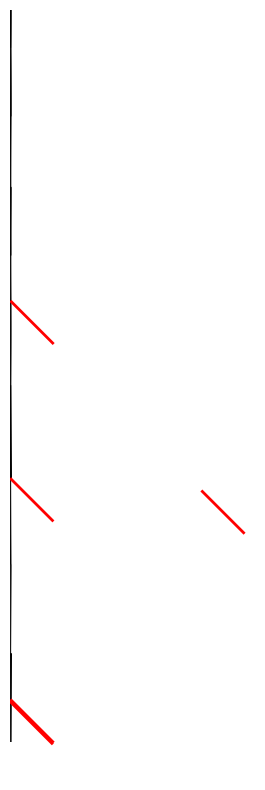

In [23]:
csv_path = '/content/problems/frag0.csv'
path_XYs = read_csv_(csv_path)
image = load_image_from_csv('/content/problems/frag0.csv')
curves = detect_curves(image)
bezier_curves = [fit_bezier_curve(curve) for curve in curves]
symmetry_lines = find_symmetry_lines(bezier_curves)
draw_symmetry_lines(image, symmetry_lines)

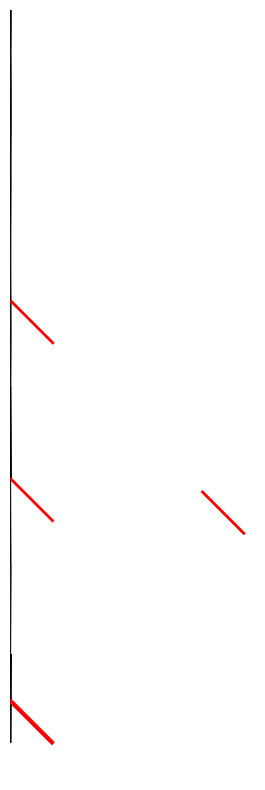

In [27]:
csv_path = '/content/problems/frag1.csv'
path_XYs = read_csv_(csv_path)
image = load_image_from_csv('/content/problems/frag1.csv')
curves = detect_curves(image)
bezier_curves = [fit_bezier_curve(curve) for curve in curves]
symmetry_lines = find_symmetry_lines(bezier_curves)
draw_symmetry_lines(image, symmetry_lines)

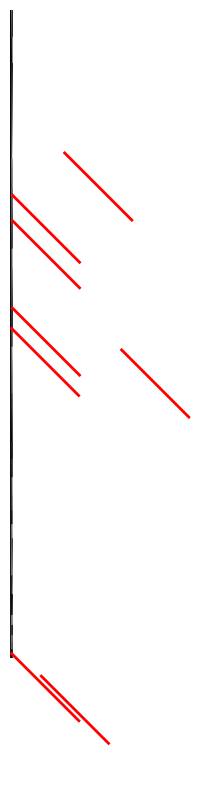

In [26]:
csv_path = '/content/problems/frag2.csv'
path_XYs = read_csv_(csv_path)
image = load_image_from_csv('/content/problems/frag2.csv')
curves = detect_curves(image)
bezier_curves = [fit_bezier_curve(curve) for curve in curves]
symmetry_lines = find_symmetry_lines(bezier_curves)
draw_symmetry_lines(image, symmetry_lines)

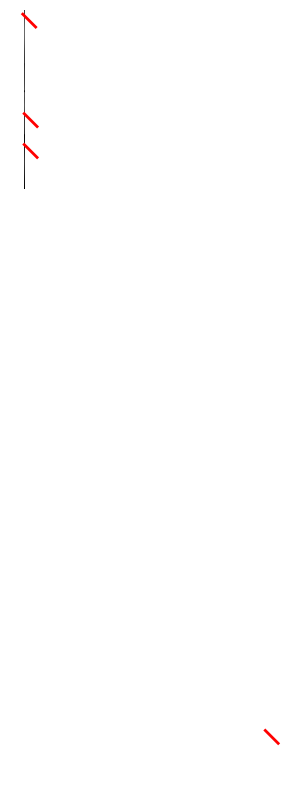

In [25]:
csv_path = '/content/problems/isolated.csv'
path_XYs = read_csv_(csv_path)
image = load_image_from_csv('/content/problems/isolated.csv')
curves = detect_curves(image)
bezier_curves = [fit_bezier_curve(curve) for curve in curves]
symmetry_lines = find_symmetry_lines(bezier_curves)
draw_symmetry_lines(image, symmetry_lines)

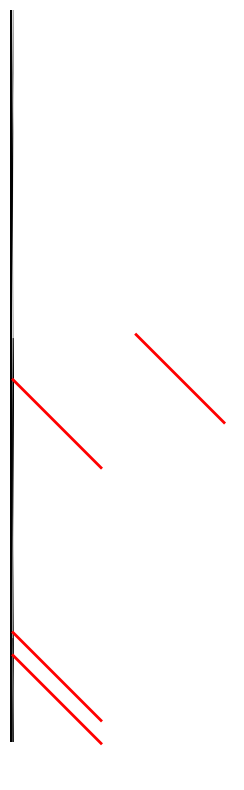

In [24]:
csv_path = '/content/problems/occlusion1.csv'
path_XYs = read_csv_(csv_path)
image = load_image_from_csv('/content/problems/occlusion1.csv')
curves = detect_curves(image)
bezier_curves = [fit_bezier_curve(curve) for curve in curves]
symmetry_lines = find_symmetry_lines(bezier_curves)
draw_symmetry_lines(image, symmetry_lines)

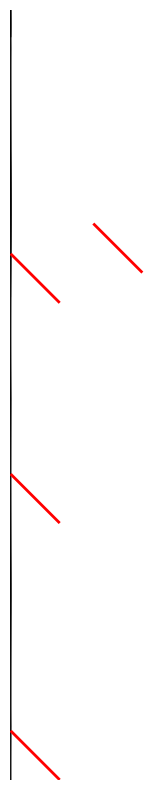

In [28]:
csv_path = '/content/problems/occlusion2.csv'
path_XYs = read_csv_(csv_path)
image = load_image_from_csv('/content/problems/occlusion2.csv')
curves = detect_curves(image)
bezier_curves = [fit_bezier_curve(curve) for curve in curves]
symmetry_lines = find_symmetry_lines(bezier_curves)
draw_symmetry_lines(image, symmetry_lines)